# **Reinforcement Learning**
<img align="right" src="https://vitalflux.com/wp-content/uploads/2020/12/Reinforcement-learning-real-world-example.png">

- In reinforcement learning, your system learns how to interact intuitively with the environment by basically doing stuff and watching what happens.

if you need the last version of gym use block of code below:

```sh
!pip uninstall gym -y
!pip install gym
```
<br>

And here is gymnasium version:

```python
gymnasium.__version__
```
1.2.0

In [ ]:
# !pip install -U gym==0.25.2
!pip install swig
!pip install gymnasium[atari]
!pip install gymnasium[box2d]
!pip install gymnasium[accept-rom-license]
# !pip install autorom[accept-rom-license]

In [2]:
import random
from tqdm.auto import tqdm
from collections import defaultdict, deque
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from IPython.core.display import HTML
from base64 import b64encode
from gym.wrappers import record_video, record_episode_statistics
from gym.wrappers import RecordVideo, RecordEpisodeStatistics
import torch
from torch.utils.data.dataset import IterableDataset
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

import warnings
warnings.filterwarnings('ignore')

In [3]:
def display_video(episode=0, video_width=600):
    """
    Displays a video from a specified episode with customizable width.

    Args:
        episode (int): The episode number to load the video for. Defaults to 0.
        video_width (int): The width of the video player in pixels. Defaults to 600.

    Returns:
        IPython.display.HTML: An HTML video element that can be rendered in Jupyter notebooks.

    Note:
        - The function expects video files to be in './video/' directory with naming format 'rl-video-episode-{N}.mp4'
        - Videos are base64 encoded and embedded directly in the HTML for display
    """
    # Construct the path to the video file based on episode number
    video_path = f"./video/rl-video-episode-{episode}.mp4"

    # Read the video file as binary data
    video_file = open(video_path, "rb").read()

    # Encode the binary video data as base64 string
    decoded = b64encode(video_file).decode()

    # Create a data URL for the video
    video_url = f"data:video/mp4;base64,{decoded}"

    # Return an HTML video element with the embedded video
    return HTML(f"""<video width="{video_width}"" controls><source src="{video_url}"></video>""")

def create_env(name, render_mode="rgb_array", record=False, eps_record=50, video_folder='./video'):
    """
    Creates and configures a Gym environment with optional video recording and statistics tracking.

    Args:
        name (str): Name of the Gym environment to create (e.g., 'CartPole-v1')
        render_mode (str): Rendering mode - "human", "rgb_array", or "ansi". Defaults to "rgb_array"
        record (bool): Whether to record videos of the environment. Defaults to False
        eps_record (int): Record a video every N episodes (when record=True). Defaults to 50
        video_folder (str): Directory to save recorded videos. Defaults to './video'

    Returns:
        gym.Env: Configured Gym environment wrapped with recording and statistics tracking

    Note:
        - When record=True, videos will be saved in the specified folder with automatic naming
        - The environment is always wrapped with episode statistics tracking
    """
    # Create base Gym environment with specified render mode
    env = gym.make(name, render_mode=render_mode)

    # Optionally wrap environment with video recorder
    if record:
        # Record video every eps_record episodes (trigger function)
        env = RecordVideo(env, video_folder=video_folder,
                         episode_trigger=lambda x: x % eps_record == 0)

    # Always wrap environment with episode statistics tracker
    env = RecordEpisodeStatistics(env)

    return env

def show_reward(total_rewards):
    """
    Plots the progression of rewards across episodes using matplotlib.

    Args:
        total_rewards (list or array-like): A sequence of reward values obtained per episode.

    Displays:
        A line plot showing the reward trend over episodes with:
        - X-axis: Episode number
        - Y-axis: Reward value

    Note:
        - This function immediately displays the plot using plt.show()
        - The plot uses default matplotlib styling
        - Useful for visualizing training progress in reinforcement learning
    """
    # Create line plot of reward values
    plt.plot(total_rewards)

    # Label the x-axis as 'Episode'
    plt.xlabel('Episode')

    # Label the y-axis as 'Reward'
    plt.ylabel('Reward')

    # Display the plot
    plt.show()

## **Temporal Difference method**

Previously, we solved MDPs by means of the Monte Carlo method, which is a model-free approach that requires no prior knowledge of the environment. We will employ the **temporal difference (TD)** method in this notebook. In the TD method, we update the action values in every time step in an episode, which increases learning efficiency significantly.

As we saw for Monte Carlo methods, Prediction refers to the problem of estimating **the values of states ($V(s)$), which is an indication of how good is that state** for an agent in the given environment, the higher the value of the state the better it is to be in that state.

**Monte Carlo** methods wait until the return following the visit is known which is after the episode ends is available to update the value of the state.

$$
\large V(s_t) ← V(s_t) + \alpha[G_t- V(s_t)]
$$

whereas **TD methods** update the state value in the next time step **(Bootstrapping)**, at the next time step $t+1$ they immediately form a target and make a useful update using the observed reward.

$$
\large V(s_t) ← V(s_t) + \alpha[R_{t+1} + \gamma V_{s_{t+1}} - V_{s_t}]
$$

In the TD update equation, the quantity in brackets is a measure of an error, measuring the difference between the estimated value of $S_t$ and the better estimate at the next time step. This quantity is called the **TD error** which has a widespread presence in all reinforcement learning.

<br>

$$
\large \delta \doteq R_{t+1} + \gamma V_(s_{t+1}) - V(s_t)
$$

> $\doteq$: specifying the $\delta$ meaning or value

<br>

Updating the state value just after one time step is called one-step TD or TD(0), In addition to that, TD methods are proven to be sound and guarantee convergence. For any fixed policy $\pi$, TD(0) has been proved to converge to the optimal value with probability 1 if the step-size parameter (alpha) decreases according to the usual stochastic approximation conditions.

**TD Control**
Control problem refers to the problem of estimating optimal policies, as with Monte Carlo methods we use the Generalized Policy Iteration for solving the control problem and similarly face the same trade-off between exploitation and exploration, as a solution to which our approach falls in either of the two categories: **on-policy** and **off-policy**.

<br>

**From previous notebook**
---

- **On-policy** methods learn about the optimal policy by executing the policy and evaluating and improving it
- **off-policy** methods learn about the optimal policy using data generated by another policy.

> The way on-policy MC control works is quite similar to policy iteration in dynamic programming, which has two phases, evaluation and improvement.<br>
**In the evaluation phase**, instead of evaluating the $V(S)$, it evaluates the $Q(s, a)$.<br>
**In the improvement phase**, the policy is updated by assigning the optimal action to each state:<br>
$$
\pi(s) = \underset{a}{argmax}Q(s, a)
$$

> The off-policy method optimizes the **target policy** ($\pi(a, s)$), using data generated by another policy, called the **behavior policy** ($b(a, s)$). The target policy performs **exploitation, which is evaluation pahse,** all the time while the behavior policy is for **exploration, which is training phase,** purposes. This means that the target policy is greedy with respect to its current Q-function, and the behavior policy generates behavior so that the target policy has data to learn from.

---

## **Cliff Walking Environment**

<img width="400" align="right" src="https://www.gymlibrary.dev/_images/cliff_walking.gif">


<br>

<table>
<tr>
    <td><font size="3">Action Space</td>
    <td><font size="3">Discrete(4)</td>
</tr>
<tr>
    <td><font size="3">Observation Space</td>
    <td><font size="3">Discrete(48))</td>
</tr>

<tr>
    <td><font size="3">Import</td>
    <td><font size="4"><code>gym.make("CliffWalking-v0")</code></td>
<tr>

In [5]:
env = create_env("CliffWalking-v1")

## **Developing the SARSA algorithm**

We are going to start with one-step **on-policy** learning, **State-Action-Reward-State-Action (SARSA)** focuses on state-action values. It updates the Q-function based on the following equation:

<br>

$$
\large \textit{SARSA algorithm} \\
\large Q(s, a) ← Q(s, a) + \alpha[r + \gamma Q(s', a') - Q(s, a)]
$$

<br>

$$
\large \delta = r + \gamma Q(s', a') - Q(s, a)
$$

<br>

> Here, $s'$ is the resulting state after taking the action, $a$, in state $s$;<br>
$r$ is the associated reward;<br>
$α$ is the learning rate;<br>
$γ$ is the discount factor.

In SARSA, we simply pick up the next action, $a'$, by also following an epsilon-greedy policy(current policy) to update the Q value. And the action $a'$ is taken in the next step. Hence, SARSA is an on-policy algorithm, since both $a$ and $a'$ generate using a same policy.

<br>

>**Note**: In all espisodic tasks terminal states have $Q(s, a) = 0$, so for terminal state states:<br>
$$
\large Q(s, a) ← Q(s, a) + \alpha[r - Q(s, a)]
$$

In [6]:
def take_action(state, Q, epsilon, n_action):
    """
    Selects an action for a given state using an epsilon-greedy policy.

    Parameters:
        state (int): The current state for which an action is to be chosen.
        Q (dict): A dictionary where Q[state][action] represents the estimated value of taking
                  'action' in 'state'.
        epsilon (float): The probability of choosing a random action for exploration (0 <= epsilon <= 1).
        n_action (int): The total number of possible actions.

    Returns:
        action (int): The chosen action.
    """

    # Generate a random number to decide between exploration or exploitation
    if np.random.random() < epsilon:
        # Exploration: Choose a random action with uniform probability
        return torch.randint(0, n_action, (1,)).item()
    else:
        # Exploitation: Choose the action with the highest Q-value for the current state
        return torch.argmax(Q[state]).item()

def take_action2(state, Q, epsilon, n_action):
    """
    Selects an action for a given state using an epsilon-greedy policy.

    Parameters:
        state (int): The current state for which an action is to be chosen.
        Q (dict): A dictionary where Q[state][action] represents the estimated value of taking
                  'action' in 'state'.
        epsilon (float): The probability of choosing a random action for exploration (0 <= epsilon <= 1).
        n_action (int): The total number of possible actions.

    Returns:
        action (int): The chosen action.
    """
    # Initialize a probability distribution for all actions, with each action having an equal probability
    # of being selected (epsilon / n_action).
    probs = torch.ones(n_action) * epsilon / n_action

    # Find the action with the highest Q-value for the current state (exploitation).
    best_action = np.argmax(Q[state])

    # Increase the probability of selecting the best action by the remaining probability (1 - epsilon).
    probs[best_action] += (1.0 - epsilon)

    # Sample an action based on the computed probability distribution.
    action = torch.multinomial(probs, 1).item()

    return action

In [21]:
def SARSA(env, gamma, n_episode, alpha, epsilon,
          epsilon_decay=0.995, epsilon_min=0.01, show=True):
    """
    Implements the SARSA (State-Action-Reward-State-Action) algorithm for reinforcement learning.

    Parameters:
        env (gym.Env): The environment to interact with.
        gamma (float): The discount factor for future rewards (0 <= gamma <= 1).
        n_episode (int): The number of episodes to run.
        alpha (float): The learning rate (0 < alpha <= 1).
        epsilon (float): Initial exploration rate for ε-greedy policy (0 ≤ epsilon ≤ 1).
                        Probability of taking a random action.
        epsilon_decay (float): Rate at which epsilon decays each episode (0 < decay ≤ 1).
                              Typical values: 0.995-0.999 for gradual decay.
        epsilon_min (float): Minimum exploration rate. Prevents epsilon from decaying to 0.
                            Suggested: 0.01-0.1 for continued exploration.
        show (bool): If True, plots episode rewards and lengths over time.

    Returns:
        Q (defaultdict): The action-value function learned through SARSA.
        policy (dict): The optimal policy derived from Q.
    """
    # Number of possible actions in the environment
    n_action = env.action_space.n

    # Initialize the Q-value table with zero vectors for each state
    Q = defaultdict(lambda: torch.zeros(n_action))

    # Arrays to track episode lengths and total rewards
    length_episode = [0] * n_episode  # Number of steps per episode
    total_reward_episode = [0] * n_episode  # Total reward per episode

    # Loop through each episode
    pbar = tqdm(range(n_episode), desc="Episodes")
    for episode in pbar:
        # Reset the environment at the start of each episode
        state, _ = env.reset()
        done = False  # Flag to indicate if the episode has ended

        # Select an initial action using the epsilon-greedy policy
        action = take_action(state, Q, epsilon, n_action)

        # Iterate through the episode until it ends
        while not done:
            # Take the chosen action and observe the next state, reward, and done flag
            next_state, reward, done, _ = env.step(action)

            # Select the next action using the epsilon-greedy policy
            next_action = take_action(next_state, Q, epsilon, n_action)

            if not done:
                # Compute the TD (Temporal Difference) error
                td_delta = reward + gamma * Q[next_state][next_action] - Q[state][action]
            else:
                # If the episode ends, the TD error should not include future rewards
                td_delta = reward - Q[state][action]

            # Update the Q-value for the current state-action pair
            Q[state][action] += alpha * td_delta

            # Update the current state and action
            state = next_state
            action = next_action

            # Track the length of the episode
            length_episode[episode] += 1

            # Track the total reward for this episode
            total_reward_episode[episode] += reward

        # Decay epsilon (but not below minimum)
        epsilon = max(epsilon * epsilon_decay, epsilon_min)

        # Compute and print the average total reward over past 50 completed episodes
        start = episode - 50 if episode > 50 else 0
        avg_tot_reward = np.array(total_reward_episode[start:]).mean()
        pbar.set_description(
            f"Average reward over past 50 episodes: {avg_tot_reward:.2f} | "
            f"ε: {epsilon:.2f}"
        )

    # Derive the optimal policy from the Q-value table
    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()  # Choose the action with the highest Q-value

    # If `show` is True, plot the rewards and lengths of episodes
    if show:
        fig = plt.figure(figsize=(12, 4))

        # Plot total reward per episode
        fig.add_subplot(1, 2, 1)
        plt.plot(total_reward_episode)
        plt.title('Episode reward over time')
        plt.xlabel('Episode')
        plt.ylabel('Total reward')

        # Plot episode length over time
        fig.add_subplot(1, 2, 2)
        plt.plot(length_episode)
        plt.title('Episode length over time')
        plt.xlabel('Episode')
        plt.ylabel('Length')

        plt.show()

    return Q, policy  # Return the learned Q-values and the derived policy

Episodes:   0%|          | 0/500 [00:00<?, ?it/s]

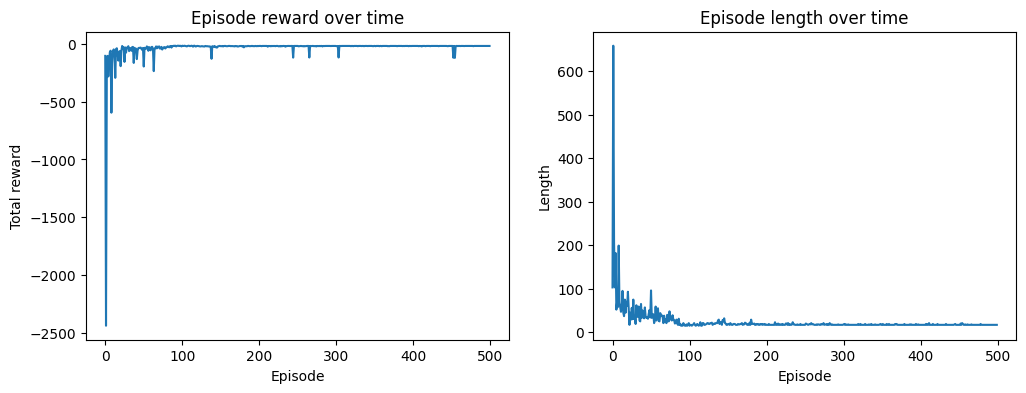

In [28]:
env = create_env("CliffWalking-v1", record=True, eps_record=50)
gamma = 0.99
n_episode = 500
alpha = 0.3
epsilon = 0.15
optimal_q, optimal_policy = SARSA(env, gamma, n_episode, alpha, epsilon, show=True)

In [30]:
display_video(450)

## **Developing the Q-learning algorithm**

Q-learning is an off-policy learning algorithm. It updates the Q-function based on the following equation:

<br>

$$
\large \textit{Q-learning algorithm} \\
\large Q(s, a) ← Q(s, a) + \alpha[r + \gamma \underset{a'}{max} Q(s', a') - Q(s, a)]
$$

<br>

$$
\large \textit{SARSA algorithm} \\
\large Q(s, a) ← Q(s, a) + \alpha[r + \gamma Q(s', a') - Q(s, a)]
$$

<br>

> Here, $s'$ is the resulting state after taking action, $a$, in state $s$;<br> $r$ is the associated reward;<br> $α$ is the learning rate; and<br> $γ$ is the discount factor.

Also, means that the behavior policy is greedy, in SARSA it's epsilon-greedy, where the highest Q-value among those in state s' is selected to generate learning data. In Q-learning, actions are taken according to the **epsilon-greedy policy**.

In [33]:
def q_learning(env, gamma, n_episode, alpha, epsilon,
               epsilon_decay=0.995, epsilon_min=0.01, show=True):
    """
    Implements the Q-learning algorithm for reinforcement learning.

    Parameters:
        env (gym.Env): The environment to interact with.
        gamma (float): The discount factor for future rewards (0 <= gamma <= 1).
        n_episode (int): The number of episodes to run.
        alpha (float): The learning rate (0 < alpha <= 1).
        epsilon (float): Initial exploration rate for ε-greedy policy (0 ≤ epsilon ≤ 1).
                        Probability of taking a random action.
        epsilon_decay (float): Rate at which epsilon decays each episode (0 < decay ≤ 1).
                              Typical values: 0.995-0.999 for gradual decay.
        epsilon_min (float): Minimum exploration rate. Prevents epsilon from decaying to 0.
                            Suggested: 0.01-0.1 for continued exploration.
        show (bool): If True, plots episode rewards and lengths over time.
        show (bool): If True, plots episode rewards and lengths over time.

    Returns:
        Q (defaultdict): The action-value function learned through Q-learning.
        policy (dict): The optimal policy derived from Q.
    """
    # Number of possible actions in the environment
    n_action = env.action_space.n

    # Initialize the Q-value table with zero vectors for each state
    Q = defaultdict(lambda: torch.zeros(n_action))

    # Arrays to track episode lengths and total rewards
    length_episode = [0] * n_episode  # Number of steps per episode
    total_reward_episode = [0] * n_episode  # Total reward per episode

    # Loop through each episode
    pbar = tqdm(range(n_episode), desc="Episodes")
    for episode in pbar:
        # Reset the environment at the start of each episode
        state, _ = env.reset()
        done = False  # Flag to indicate if the episode has ended

        # Iterate through the episode until it ends
        while not done:
            # Select an action using the epsilon-greedy policy
            action = take_action(state, Q, epsilon, n_action)

            # Take the chosen action and observe the next state, reward, and done flag
            next_state, reward, done, _ = env.step(action)

            # Compute the TD (Temporal Difference) error for Q-learning
            # Q-learning uses the maximum Q-value of the next state (off-policy update)
            td_delta = reward + gamma * torch.max(Q[next_state]) - Q[state][action]

            # If the episode ends, the TD error should not include future rewards
            if done:
                td_delta = reward - Q[state][action]

            # Update the Q-value for the current state-action pair
            Q[state][action] += alpha * td_delta

            # Update the current state
            state = next_state

            # Track the length of the episode
            length_episode[episode] += 1

            # Track the total reward for this episode
            total_reward_episode[episode] += reward

        # Decay epsilon (but not below minimum)
        epsilon = max(epsilon * epsilon_decay, epsilon_min)

        # Compute and print the average total reward over past 50 completed episodes
        start = episode - 50 if episode > 50 else 0
        avg_tot_reward = np.array(total_reward_episode[start:]).mean()
        pbar.set_description(
            f"Average reward over past 50 episodes: {avg_tot_reward:.2f} | "
            f"ε: {epsilon:.2f}"
        )

    # Derive the optimal policy from the Q-value table
    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()  # Choose the action with the highest Q-value

    # If `show` is True, plot the rewards and lengths of episodes
    if show:
        fig = plt.figure(figsize=(12, 4))

        # Plot total reward per episode
        fig.add_subplot(1, 2, 1)
        plt.plot(total_reward_episode)
        plt.title('Episode reward over time')
        plt.xlabel('Episode')
        plt.ylabel('Total reward')

        # Plot episode length over time
        fig.add_subplot(1, 2, 2)
        plt.plot(length_episode)
        plt.title('Episode length over time')
        plt.xlabel('Episode')
        plt.ylabel('Length')

        plt.show()

    return Q, policy  # Return the learned Q-values and the derived policy

Episodes:   0%|          | 0/500 [00:00<?, ?it/s]

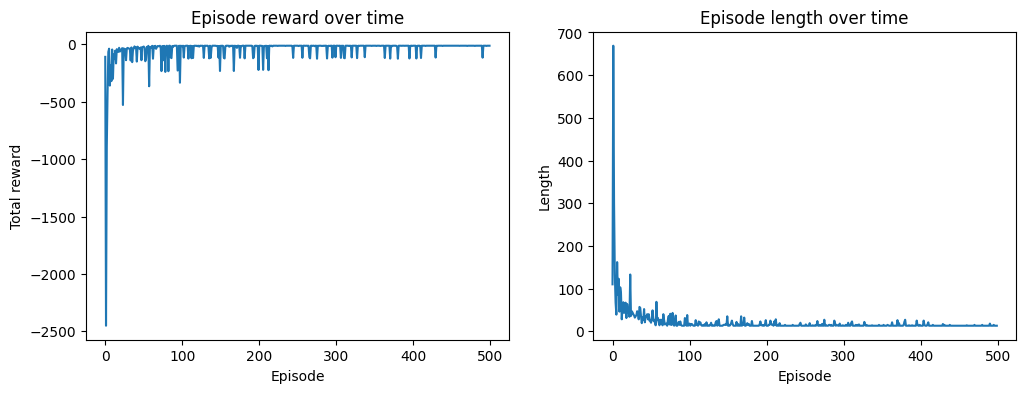

In [34]:
env = create_env("CliffWalking-v1", record=True, eps_record=50)
gamma = 0.99
n_episode = 500
alpha = 0.3
epsilon = 0.15
optimal_q, optimal_policy = q_learning(env, gamma, n_episode, alpha, epsilon, show=True)

In [35]:
display_video(400)

## **Taxi Environment**

<img width="400" align="right" src="https://www.gymlibrary.dev/_images/taxi.gif">


<br>

<table>
<tr>
    <td><font size="3">Action Space</td>
    <td><font size="3">Discrete(6)</td>
</tr>
<tr>
    <td><font size="3">Observation Space</td>
    <td><font size="3">Discrete(500))</td>
</tr>

<tr>
    <td><font size="3">Import</td>
    <td><font size="4"><code>gym.make("Taxi-v3")</code></td>
<tr>

Episodes:   0%|          | 0/500 [00:00<?, ?it/s]

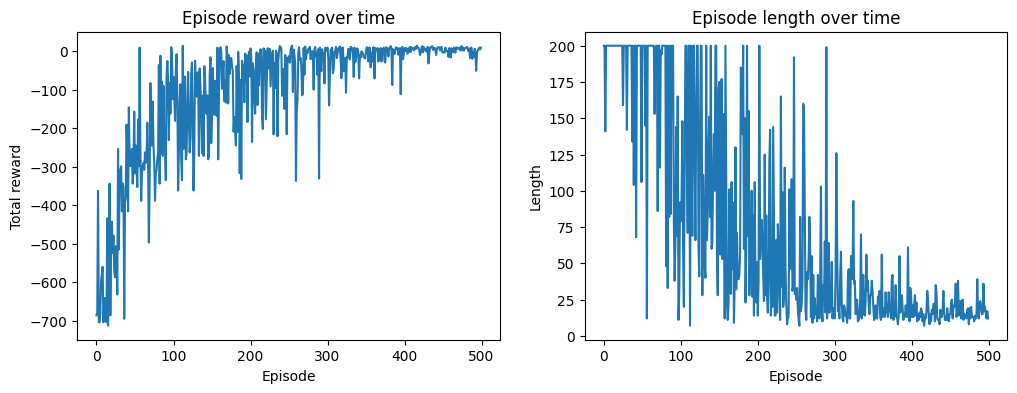

In [37]:
env = create_env("Taxi-v3", record=True, eps_record=50)
gamma = 0.99
n_episode = 500
alpha = 0.4
epsilon = 0.15
optimal_q, optimal_policy = SARSA(env, gamma, n_episode, alpha, epsilon)

In [38]:
display_video(450)

Episodes:   0%|          | 0/500 [00:00<?, ?it/s]

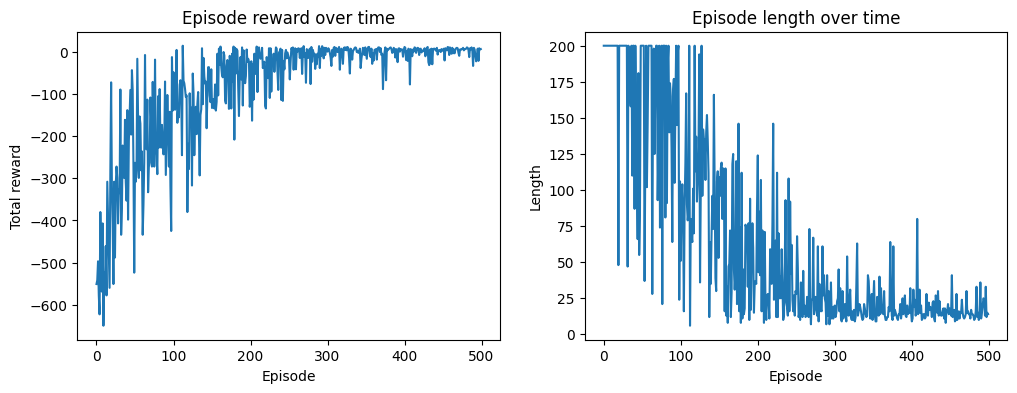

In [40]:
env = create_env("Taxi-v3", record=True, eps_record=50)
gamma = 0.99
n_episode = 500
alpha = 0.4
epsilon = 0.15
optimal_q, optimal_policy = q_learning(env, gamma, n_episode, alpha, epsilon)

In [43]:
display_video(450)

## **Developing the Double Q-learning algorithm - Maximize bias**

Q-learning is a powerful and popular TD control reinforcement learning algorithm. However, it may perform poorly in some cases, mainly because of the greedy component, $\underset{a'}{max} Q(s', a')$. It can overestimate action values and result in poor performance. Double Qlearning was invented to overcome this by utilizing two Q functions. We denote two Q functions as $Q_1$ and $Q_2$. In each step, one Q function is randomly selected to be updated. If $Q_1$ is selected, $Q_1$ is updated as follows:

<br>

$$
\large a^* = \underset{a}{argmax} Q_1(s', a),  \\
\\ \large Q_1(s, a) ← Q_1(s, a) + \alpha[r + \gamma Q_2(s', a^*) - Q_1(s, a)]
$$

<br>

If $Q_2$ is selected, it is updated as follows:

<br>

$$
\large a^* = \underset{a}{argmax} Q_2(s', a),  \\
\\ \large Q_2(s, a) ← Q_2(s, a) + \alpha[r + \gamma Q_1(s', a^*) - Q_2(s, a)]
$$

> One Q-value is used to find the action that maximizes the Q-value, and the other set of Q-values is then used to find the Q-value for that max action

In [44]:
def double_q_learning(env, gamma, n_episode, alpha, epsilon,
                      epsilon_decay=0.995, epsilon_min=0.1, show=True):
    """
    Implements the Double Q-learning algorithm to reduce overestimation bias in Q-learning.

    Parameters:
        env (gym.Env): The environment to interact with.
        gamma (float): The discount factor for future rewards (0 <= gamma <= 1).
        n_episode (int): The number of episodes to run.
        alpha (float): The learning rate (0 < alpha <= 1).
        epsilon (float): Initial exploration rate for ε-greedy policy (0 ≤ epsilon ≤ 1).
                        Probability of taking a random action.
        epsilon_decay (float): Rate at which epsilon decays each episode (0 < decay ≤ 1).
                              Typical values: 0.995-0.999 for gradual decay.
        epsilon_min (float): Minimum exploration rate. Prevents epsilon from decaying to 0.
                            Suggested: 0.01-0.1 for continued exploration.
        show (bool): If True, plots episode rewards and lengths over time.

    Returns:
        Q (torch.Tensor): The combined Q-values from Q1 and Q2.
        policy (dict): The optimal policy derived from the combined Q-values.
    """
    # Number of actions and states in the environment
    n_action = env.action_space.n
    n_state = env.observation_space.n

    # Initialize two separate Q-value tables (Q1 and Q2) with zeros
    Q1 = torch.zeros(n_state, n_action)
    Q2 = torch.zeros(n_state, n_action)

    # Track episode lengths and total rewards
    length_episode = [0] * n_episode  # Number of steps per episode
    total_reward_episode = [0] * n_episode  # Total reward per episode

    # Loop through each episode
    pbar = tqdm(range(n_episode), desc="Episodes")
    for episode in pbar:
        # Reset the environment for each episode
        state, _ = env.reset()
        done = False  # Flag to indicate if the episode has ended

        while not done:
            # Use an epsilon-greedy policy to select an action based on the combined Q-values
            action = take_action(state, Q1 + Q2, epsilon, n_action)

            # Take the selected action and observe the next state, reward, and done flag
            next_state, reward, done, _ = env.step(action)

            # Update either Q1 or Q2 based on a random choice
            if torch.rand(1).item() < 0.5:
                # Update Q1 using the best action from Q2
                best_next_action = torch.argmax(Q1[next_state])
                td_delta = reward + gamma * Q2[next_state][best_next_action] - Q1[state][action]
                Q1[state][action] += alpha * td_delta
            else:
                # Update Q2 using the best action from Q1
                best_next_action = torch.argmax(Q2[next_state])
                td_delta = reward + gamma * Q1[next_state][best_next_action] - Q2[state][action]
                Q2[state][action] += alpha * td_delta

            # Move to the next state
            state = next_state

            # Track the length of the episode
            length_episode[episode] += 1

            # Track the total reward for this episode
            total_reward_episode[episode] += reward

        # Decay epsilon (but not below minimum)
        epsilon = max(epsilon * epsilon_decay, epsilon_min)

        # Compute and print the average total reward over past 50 completed episodes
        start = episode - 50 if episode > 50 else 0
        avg_tot_reward = np.array(total_reward_episode[start:]).mean()
        pbar.set_description(
            f"Average reward over past 50 episodes: {avg_tot_reward:.2f} | "
            f"ε: {epsilon:.2f}"
        )

    # Derive the optimal policy from the combined Q-values (Q1 + Q2)
    policy = {}
    Q = Q1 + Q2  # Combine the two Q-tables
    for state in range(n_state):
        policy[state] = torch.argmax(Q[state]).item()  # Select the action with the highest Q-value

    # If `show` is True, plot the rewards and lengths of episodes
    if show:
        fig = plt.figure(figsize=(12, 4))

        # Plot total reward per episode
        fig.add_subplot(1, 2, 1)
        plt.plot(total_reward_episode)
        plt.title('Episode reward over time')
        plt.xlabel('Episode')
        plt.ylabel('Total reward')

        # Plot episode length over time
        fig.add_subplot(1, 2, 2)
        plt.plot(length_episode)
        plt.title('Episode length over time')
        plt.xlabel('Episode')
        plt.ylabel('Length')

        plt.show()

    return Q, policy  # Return the combined Q-values and the derived policy

Episodes:   0%|          | 0/1000 [00:00<?, ?it/s]

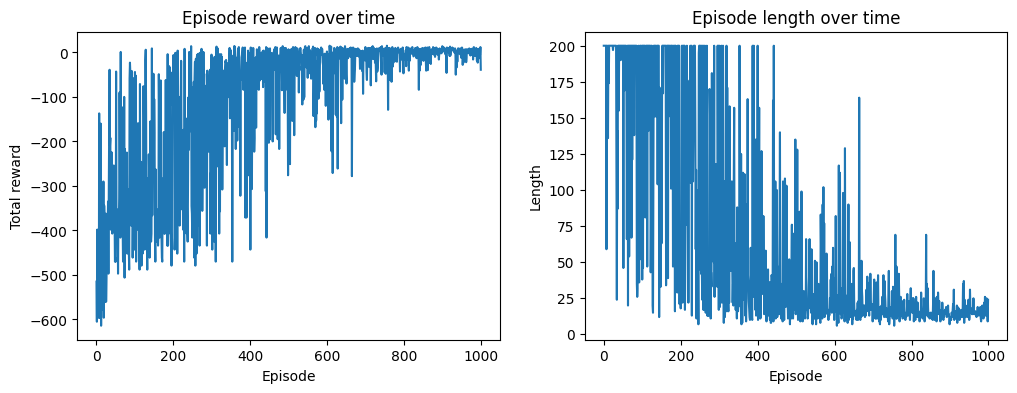

In [45]:
env = create_env("Taxi-v3", record=True, eps_record=50)
gamma = 0.99
n_episode = 1000
alpha = 0.4
epsilon = 0.15
optimal_q, optimal_policy = double_q_learning(env, gamma, n_episode, alpha, epsilon, show=True)

In [46]:
display_video(950)

## **Expected SARSA Control - Minimize variance**

Which is a hybrid between Q-learning and SARSA. $max$ in Q-learning algorithm is repolaced with $Expectaion$:

<br>

$$
\large \textit{Expected SARSA algorithm} \\
\large Q(s, a) ← Q(s, a) + \alpha[r + \gamma \sum_{a} \pi(a|s^{'}).Q(s', a) - Q(s, a)]
$$

<br>

$$
\large \textit{Q-learning algorithm} \\
\large Q(s, a) ← Q(s, a) + \alpha[r + \gamma max_{a'} Q(s', a') - Q(s, a)]
$$

<br>

$$
\large \textit{SARSA algorithm} \\
\large Q(s, a) ← Q(s, a) + \alpha[r + \gamma Q(s', a') - Q(s, a)]
$$

<br>

Instead of sampling, we take the expectation over all possible actions. we can set the learning rate $α = 1$ without any major impact on the learning quality.

In [47]:
def Expected_SARSA(env, gamma, n_episode, alpha, epsilon = 0.1,
                   epsilon_decay = 0.995, epsilon_min = 0.05, show=True):
    """
    Implements the Expected SARSA algorithm for reinforcement learning.

    Parameters:
        env: The environment to train on (must follow OpenAI Gym interface).
        gamma (float): Discount factor for future rewards (0 ≤ gamma ≤ 1).
        n_episode (int): Number of episodes to train for.
        alpha (float): Learning rate for Q-value updates.
        epsilon (float): Initial exploration rate for ε-greedy policy (0 ≤ epsilon ≤ 1).
                        Probability of taking a random action.
        epsilon_decay (float): Rate at which epsilon decays each episode (0 < decay ≤ 1).
                              Typical values: 0.995-0.999 for gradual decay.
        epsilon_min (float): Minimum exploration rate. Prevents epsilon from decaying to 0.
                            Suggested: 0.01-0.1 for continued exploration.
        show (bool): If True, plot the episode rewards and lengths at the end.

    Returns:
        Q (defaultdict): Learned Q-value table.
        policy (dict): The derived policy mapping states to optimal actions.
    """

    # Number of possible actions in the environment
    n_action = env.action_space.n

    # Initialize the Q-value table with zero vectors for each state
    Q = defaultdict(lambda: torch.zeros(n_action))

    # Arrays to track episode lengths and total rewards
    length_episode = [0] * n_episode  # Number of steps per episode
    total_reward_episode = [0] * n_episode  # Total reward per episode

    # Loop through each episode
    pbar = tqdm(range(n_episode), desc="Episodes")
    for episode in pbar:
        # Reset the environment at the start of each episode
        state, _ = env.reset()
        done = False  # Flag to indicate if the episode has ended

        # Iterate through the episode until it ends
        while not done:
            # Select an action using the epsilon-greedy policy
            action = take_action(state, Q, epsilon, n_action)

            # Perform the action in the environment and observe the next state, reward, and done flag
            next_state, reward, done, _ = env.step(action)


            # Calculate Expecte_Q in vectorized form
            # probs is policy(𝜋(a|s')) in the above formula
            probs = torch.ones(n_action) * (epsilon / n_action) # for non-optimal actions: (epsilon / |A|)
            probs[torch.argmax(Q[next_state]).item()] += (1 - epsilon) # for the optimal action: (1 - epsilon) + (epsilon / |A|)
            Expected_Q = torch.sum(probs * Q[next_state])

            # Compute the temporal difference (TD) error
            td_delta = reward + gamma * Expected_Q - Q[state][action]

            # If the episode ends, the TD error should only consider the immediate reward
            if done:
                td_delta = reward - Q[state][action]

            # Update the Q-value for the current state-action pair
            Q[state][action] += alpha * td_delta

            # Move to the next state
            state = next_state

            # Track the length of the episode (number of steps)
            length_episode[episode] += 1

            # Track the total reward for this episode
            total_reward_episode[episode] += reward

        # Decay epsilon (but not below minimum)
        epsilon = max(epsilon * epsilon_decay, epsilon_min)

        # Compute and print the average total reward over past 50 completed episodes
        start = episode - 50 if episode > 50 else 0
        avg_tot_reward = np.array(total_reward_episode[start:]).mean()
        pbar.set_description(
            f"Average reward over past 50 episodes: {avg_tot_reward:.2f} | "
            f"ε: {epsilon:.2f}"
        )

    # Derive the optimal policy from the Q-value table
    policy = {}
    for state, actions in Q.items():
        # Choose the action with the highest Q-value for each state
        policy[state] = torch.argmax(actions).item()

    # If `show` is True, plot the rewards and lengths of episodes
    if show:
        fig = plt.figure(figsize=(12, 4))

        # Plot total reward per episode
        fig.add_subplot(1, 2, 1)
        plt.plot(total_reward_episode)
        plt.title('Episode reward over time')
        plt.xlabel('Episode')
        plt.ylabel('Total reward')

        # Plot episode length over time
        fig.add_subplot(1, 2, 2)
        plt.plot(length_episode)
        plt.title('Episode length over time')
        plt.xlabel('Episode')
        plt.ylabel('Length')

        plt.show()

    return Q, policy  # Return the learned Q-values and the derived policy

Episodes:   0%|          | 0/500 [00:00<?, ?it/s]

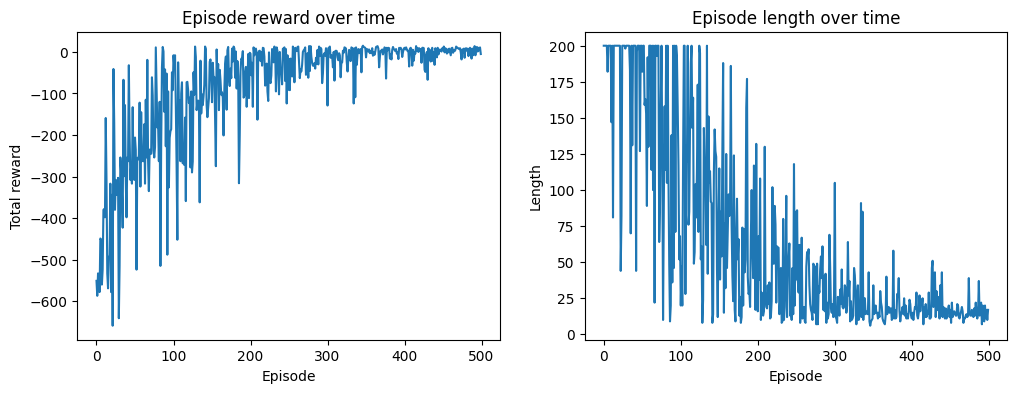

In [48]:
env = create_env("Taxi-v3", record=True, eps_record=50)
gamma = 0.99
n_episode = 500
alpha = 0.4 # we can assign 1 for alpha
epsilon = 0.15
optimal_q, optimal_policy = Expected_SARSA(env, gamma, n_episode, alpha, epsilon, show=True)

In [49]:
display_video(450)

## **Replay Buffer and Off-Policy Learning - Powerfull method**

In off-policy algorithm there are: behavior policy $b(a| s)$ to **explore** and generate examples; and $π(a| s)$, the target policy that the agent is trying to learn as the **optimal policy**. Accordingly, we could use the samples generated by the behavior policy again and again to train the agent.

In experience replay we store the samples $(s, a, r, s', done)$ in a buffer. The samples are generated using a behavior policy while we improve a deterministic target policy using q-values.

**Let’s apply this approach to the Q-learning agent.**

In [52]:
class ReplayBuffer():

    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = deque(maxlen=self.capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

In [64]:
class Q_learning():
    def __init__(self, env, gamma, n_episode, alpha, epsilon=0.15,
                 epsilon_decay=0.995, min_epsilon=0.05, batch_size=512):
        """
        Initialize the Q-learning class with hyperparameters and environment details.

        Parameters:
            env: The environment to train on (must follow OpenAI Gym interface).
            gamma (float): Discount factor for future rewards (0 ≤ gamma ≤ 1).
            n_episode (int): Number of episodes to train for.
            alpha (float): Learning rate for Q-value updates.
            epsilon (float): Initial exploration rate for ε-greedy policy (0 ≤ epsilon ≤ 1).
                            Probability of taking a random action.
            epsilon_decay (float): Rate at which epsilon decays each episode (0 < decay ≤ 1).
                            Typical values: 0.995-0.999 for gradual decay.
            epsilon_min (float): Minimum exploration rate. Prevents epsilon from decaying to 0.
                            Suggested: 0.01-0.1 for continued exploration.
            batch_size (int): Number of samples to process in each training step.
        """

        self.env = env
        self.n_action = env.action_space.n  # Number of possible actions
        self.gamma = gamma  # Discount factor
        self.n_episode = n_episode  # Total number of episodes
        self.alpha = alpha  # Learning rate
        self.epsilon = epsilon  # Initial epsilon for exploration
        self.epsilon_decay = epsilon_decay  # Epsilon decay rate
        self.min_epsilon = min_epsilon  # Minimum epsilon value
        self.Q = defaultdict(lambda: torch.zeros(self.n_action))  # Q-value table
        self.buffer = ReplayBuffer(10_000)  # Replay buffer for experience replay
        self.batch_size = batch_size  # Batch size for training
        self.epi = 0  # Current episode index

        # Arrays to track episode lengths and total rewards
        self.length_episode = []  # Number of steps per episode
        self.total_reward_episode = []  # Total reward per episode

        # Ensure the replay buffer is filled with enough samples before training
        while len(self.buffer) < 2 * self.batch_size:
            print(f"{len(self.buffer)} sample(s) in buffer, filling...")
            self.play()

    def train(self):
        """
        Train the Q-learning agent using experiences from the replay buffer.
        """
        pbar = tqdm(range(self.n_episode), desc='Episodes')
        for episode in pbar:
            # Play an episode and store experiences in the buffer
            self.play(train=True)

            # Sample experiences from the replay buffer and update the Q-values
            for item in self.buffer.sample(self.batch_size):
                states, actions, rewards, next_states, done_flags = item
                self.update(states, actions, rewards, next_states, done_flags)

            # Decay epsilon after each episode (but not below minimum)
            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

            # Compute and print the average total reward over past 50 completed episodes
            start = episode - 50 if episode > 50 else 0
            avg_tot_reward = np.array(self.total_reward_episode[start:]).mean()
            pbar.set_description(
                f"Average reward over past 50 episodes: {avg_tot_reward:.2f} | "
                f"ε: {self.epsilon:.2f}"
            )


    def update(self, state, action, reward, next_state, done):
        """
        Update the Q-value for a state-action pair using the temporal difference (TD) rule.

        Parameters:
            state: Current state.
            action: Action taken in the current state.
            reward: Reward received after taking the action.
            next_state: Next state reached after taking the action.
            done (bool): Flag indicating whether the episode has ended.
        """
        if not done:
            # TD error includes discounted future rewards if the episode is not done
            td_delta = reward + self.gamma * torch.max(self.Q[next_state]) - self.Q[state][action]
        else:
            # TD error only includes immediate reward if the episode ends
            td_delta = reward - self.Q[state][action]

        # Update the Q-value for the current state-action pair
        self.Q[state][action] += self.alpha * td_delta

    def play(self, train=False):
        """
        Play a single episode, optionally updating Q-values and tracking performance.

        Parameters:
            train (bool): If True, update Q-values and track episode metrics.
        """
        # Reset the environment at the start of the episode
        state, _ = self.env.reset()
        done = False  # Flag to indicate if the episode has ended
        length_episode = 0
        total_reward_episode = 0

        # Iterate through the episode until it ends
        while not done:
            # Select an action using the epsilon-greedy policy
            action = self.take_action(state, self.Q, self.epsilon, self.n_action)

            # Take the chosen action and observe the next state, reward, and done flag
            next_state, reward, done, _ = self.env.step(action)

            # Store the experience in the replay buffer
            self.buffer.append((state, action, reward, next_state, done))

            # Update the Q-value for the current state-action pair during exploration
            self.update(state, action, reward, next_state, done)

            # Update the current state
            state = next_state

            # Update episode statistics
            if train:
                # Track the length of the episode (number of steps)
                length_episode += 1
                # Track the total reward for this episode
                total_reward_episode += reward

        if train:
            # Increment the episode counter
            self.epi += 1
            self.length_episode.append(length_episode)
            self.total_reward_episode.append(total_reward_episode)

    def take_action(self, state, Q, epsilon, n_action):
        """
        Select an action using the epsilon-greedy policy.

        Parameters:
            state: Current state.
            Q: Q-value table.
            epsilon (float): Current epsilon value for exploration.
            n_action (int): Number of possible actions.

        Returns:
            int: Selected action.
        """
        if np.random.random() < epsilon:
            # Exploration: Choose a random action
            return torch.randint(0, n_action, (1,)).item()
        else:
            # Exploitation: Choose the action with the highest Q-value for the current state
            return torch.argmax(Q[state]).item()

    def log(self):
        """
        Plot the episode rewards and lengths over time for analysis.
        """
        fig = plt.figure(figsize=(12, 4))

        # Plot total reward per episode
        fig.add_subplot(1, 2, 1)
        plt.plot(self.total_reward_episode)
        plt.title('Episode reward over time')
        plt.xlabel('Episode')
        plt.ylabel('Total reward')

        # Plot episode length over time
        fig.add_subplot(1, 2, 2)
        plt.plot(self.length_episode)
        plt.title('Episode length over time')
        plt.xlabel('Episode')
        plt.ylabel('Length')

        plt.show()

In [65]:
env = create_env("Taxi-v3", record=True, eps_record=50)
gamma = 0.99
n_episode = 500
alpha = 0.4
epsilon = 0.3
agent = Q_learning(env, gamma, n_episode, alpha, epsilon)

0 sample(s) in buffer, filling...
200 sample(s) in buffer, filling...
400 sample(s) in buffer, filling...
600 sample(s) in buffer, filling...
800 sample(s) in buffer, filling...
982 sample(s) in buffer, filling...


In [66]:
agent.train()

Episodes:   0%|          | 0/500 [00:00<?, ?it/s]

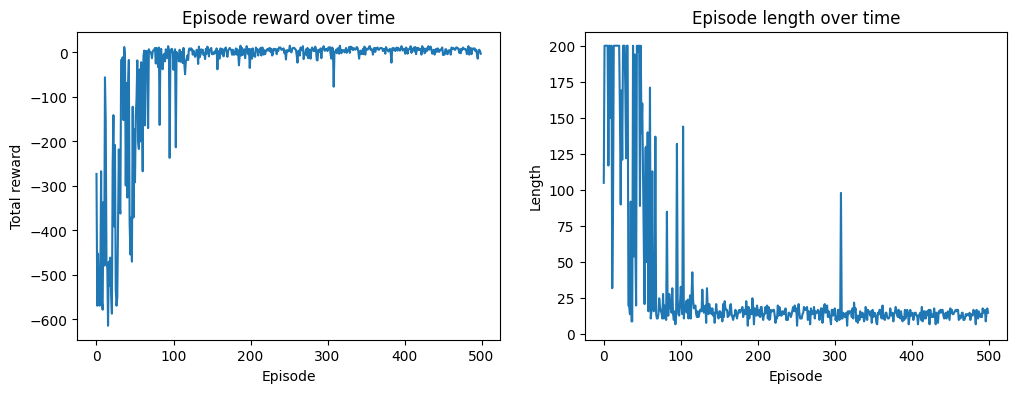

In [67]:
agent.log()

In [68]:
display_video(500)